In [1]:
import time
from typing import List

import networkx as nx
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.sparse
from tqdm.auto import tqdm

from src.python.getMatrix import getMatrixByName
from src.python.vis.visGraph import visGraph

In [2]:
def toHexagon(pos: np.ndarray, k: float) -> np.ndarray:
    n = len(pos)
    sqrtN = int(np.sqrt(n))
    args = np.argsort(pos[:, 0])
    pos[args, 0] = np.repeat(np.arange(n // sqrtN + 1), sqrtN)[:n]
    args = np.lexsort((pos[:, 1], pos[:, 0]))
    pos[args, 1] = np.tile(np.arange(sqrtN) * k, n // sqrtN + 1)[:n]
    pos[args, 1] += (pos[args, 0] % 2) * 0.5 * k
    pos[args, 0] *= 1.5 / pow(3, 0.5) * k
    return pos

In [3]:
def BFGS(
    G: nx.Graph,
    _A: scipy.sparse.coo_matrix,
    k: float,
    pos: np.ndarray,
    iterations: int = 50,
    verbose: bool = False,
) -> List[np.ndarray]:
    A = _A.tolil()
    nnodes = A.shape[0]
    dim = 2
    assert A.shape == (nnodes, nnodes)
    assert pos.shape == (nnodes, dim)

    def cost_fun(x):
        EPS = 1e-10
        pos = x.reshape((nnodes, dim))
        grad = np.zeros((nnodes, dim))
        cost = 0.0
        for i in range(nnodes):
            Ai = A.getrowview(i).toarray()
            delta = pos[i] - pos
            assert np.all(delta[i] == 0.0)
            distance = np.linalg.norm(delta, axis=1)
            cost += np.sum(Ai * distance**3 / (3 * k) - (k**2) * np.log(distance + EPS))
            distance = np.where(distance < 0.01, 0.01, distance)
            distance_inv = 1 / distance
            coefficient1 = Ai * distance / k - (k * distance_inv) ** 2
            grad[i] = coefficient1 @ delta
        return cost, grad.ravel()

    nit = 0
    hist = [pos.copy()]

    def callbackFun(*, intermediate_result: scipy.optimize.OptimizeResult):
        nonlocal nit, hist
        nit += 1
        if nit % 10 != 0:
            return
        print(f"{nit=} {intermediate_result.fun=}")
        hist.append(intermediate_result.x.reshape((nnodes, dim)).copy())
        pos = intermediate_result.x.reshape((nnodes, dim))
        if verbose:
            visGraph(G, pos, title=str(intermediate_result.fun))

    t0 = time.perf_counter()
    res = sp.optimize.minimize(
        cost_fun,
        pos.ravel(),
        method="L-BFGS-B",
        jac=True,
        options={"maxiter": iterations, "disp": verbose},
        callback=callbackFun,
    )
    t1 = time.perf_counter()
    print(f"Time: {t1-t0:.2f}s")

    if verbose:
        print("         WarnFlag and message: %d" % res.status, res.message)
        print("         Current function value: %f" % res.fun)
        print("         Iterations: %d" % res.nit)

    return hist

In [4]:
def solve(
    G: nx.Graph, A: scipy.sparse.coo_matrix, k: float, pos: np.ndarray
) -> np.ndarray:
    n = A.shape[0]
    dim = 2
    temp = 0.1
    iterations = 2000
    dt = temp / iterations
    hist = []
    t0 = time.perf_counter()
    pos = toHexagon(pos, k)
    for nit in tqdm(range(iterations)):
        delta = pos[A.row] - pos[A.col]
        distance = np.linalg.norm(delta, axis=1)
        displacement = np.zeros((n, dim))
        np.add.at(displacement, A.row, (-A.data * distance / k)[:, np.newaxis] * delta)
        displacement /= np.linalg.norm(displacement, axis=1)[:, np.newaxis] + 0.01 * k
        displacement *= temp
        pos = toHexagon(pos + displacement, k)
        if nit % 100 == 0:
            hist.append(pos.copy())
        temp -= dt
    hist.append(pos.copy())
    t1 = time.perf_counter()
    print(f"Time: {t1-t0:.2f}s")
    visGraph(G, pos)

    return pos, hist

In [5]:
def saveToOutputFile(
    A: scipy.sparse.coo_matrix, k: float, hist: List[np.ndarray], filename: str
) -> None:
    assert A.nnz % 2 == 0
    with open(filename + ".out", "w") as f:
        f.write(f"{A.shape[0]} {A.nnz//2} {k}\n")
        mask = A.row < A.col
        A_data = A.data[mask]
        A_row = A.row[mask]
        A_col = A.col[mask]
        for u, v, a in zip(A_row, A_col, A_data):
            f.write(f"{u} {v} {a}\n")
        f.write(f"{len(hist)}\n")
        for pos in hist:
            for i in range(A.shape[0]):
                f.write(f"{pos[i, 0]} {pos[i, 1]}\n")

  0%|          | 0/2000 [00:00<?, ?it/s]

Time: 1.74s


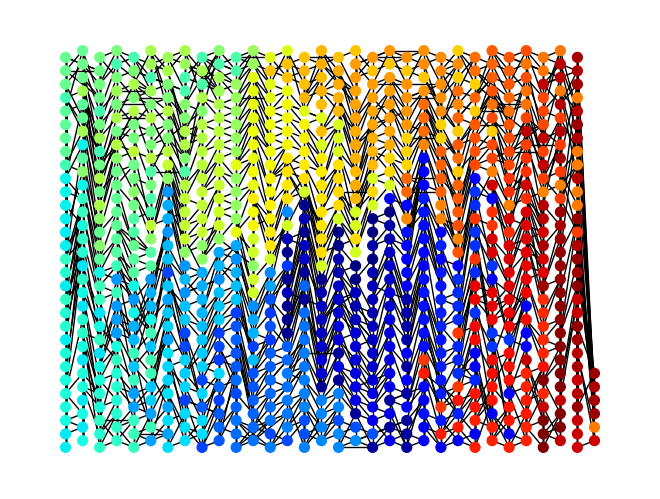

nit=10 intermediate_result.fun=np.float64(-236.29675054902805)
nit=20 intermediate_result.fun=np.float64(-478.32669829427607)
nit=30 intermediate_result.fun=np.float64(-552.692851416183)
nit=40 intermediate_result.fun=np.float64(-585.607307978524)
nit=50 intermediate_result.fun=np.float64(-596.9760803938392)
nit=60 intermediate_result.fun=np.float64(-600.8251201093218)
nit=70 intermediate_result.fun=np.float64(-603.7874349267106)
nit=80 intermediate_result.fun=np.float64(-605.2072825929416)
nit=90 intermediate_result.fun=np.float64(-605.5564190269438)
nit=100 intermediate_result.fun=np.float64(-605.6891804297729)
Time: 17.09s


In [7]:
if True:
    matrixName = "jagmesh1"
    A = getMatrixByName(matrixName)
else:
    n = 20
    matrixName = f"circle{n}"
    A = np.zeros((n, n))
    for i in range(n):
        A[i, (i + 1) % n] = 1
        A[(i + 1) % n, i] = 1


if scipy.sparse.issparse(A):
    assert scipy.sparse.linalg.norm(A - A.T) < 1e-10
    A.setdiag(0)
    A.eliminate_zeros()
    A.data = np.abs(A.data)
    A = A.tocoo()
else:
    assert np.allclose(A, A.T)
    A[np.diag_indices_from(A)] = 0
    A.data = np.abs(A.data)
    A = scipy.sparse.coo_matrix(A)

G = nx.from_scipy_sparse_array(A)
n = G.number_of_nodes()
dim = 2
k = 1.0 / np.sqrt(n)

np.random.seed(0)
posInit = np.random.random((n, dim))

# conventional
# hist_BFGS1 = BFGS(G, A, k, posInit.copy(), iterations=100)
# saveToOutputFile(A, k, hist_BFGS1, matrixName + "_BFGS")

# proposed
pos, hist_solve = solve(G, A, k, posInit.copy())
hist_BFGS2 = BFGS(G, A, k, pos, iterations=100)
saveToOutputFile(A, k, hist_solve + hist_BFGS2, matrixName + "_solve")